## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [12]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [13]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [14]:
hparams = create_hparams()
hparams.sampling_rate = 16000


In [15]:
hparams

HParams([('epochs', 500), ('iters_per_checkpoint', 1000), ('seed', 1234), ('dynamic_loss_scaling', True), ('fp16_run', False), ('distributed_run', False), ('dist_backend', 'gloo'), ('dist_url', 'tcp://localhost:54321'), ('cudnn_enabled', True), ('cudnn_benchmark', False), ('ignore_layers', ['embedding.weight']), ('load_mel_from_disk', False), ('training_files', 'E:/AlanWatts/dataset/filelists/audio_text_train_filelist.txt'), ('validation_files', 'E:/AlanWatts/dataset/filelists/audio_text_val_filelist.txt'), ('text_cleaners', ['english_cleaners']), ('max_wav_value', 32768.0), ('sampling_rate', 22050), ('filter_length', 1024), ('hop_length', 256), ('win_length', 1024), ('n_mel_channels', 80), ('mel_fmin', 0.0), ('mel_fmax', 8000.0), ('n_symbols', 148), ('symbols_embedding_dim', 512), ('encoder_kernel_size', 5), ('encoder_n_convolutions', 3), ('encoder_embedding_dim', 512), ('n_frames_per_step', 1), ('decoder_rnn_dim', 1024), ('prenet_dim', 256), ('max_decoder_steps', 1000), ('gate_thresh

#### Load model from checkpoint

In [25]:
checkpoint_path = "E:/tacotron2/checkpoints/checkpoint_304000" #tacotron2_statedict.pt
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [26]:
waveglow_path = 'E:/tacotron2/waveglow/checkpoints/waveglow_20800' #waveglow_256channels_universal_v5.pt' # 
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [76]:
text = "we have been educated to use our minds"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

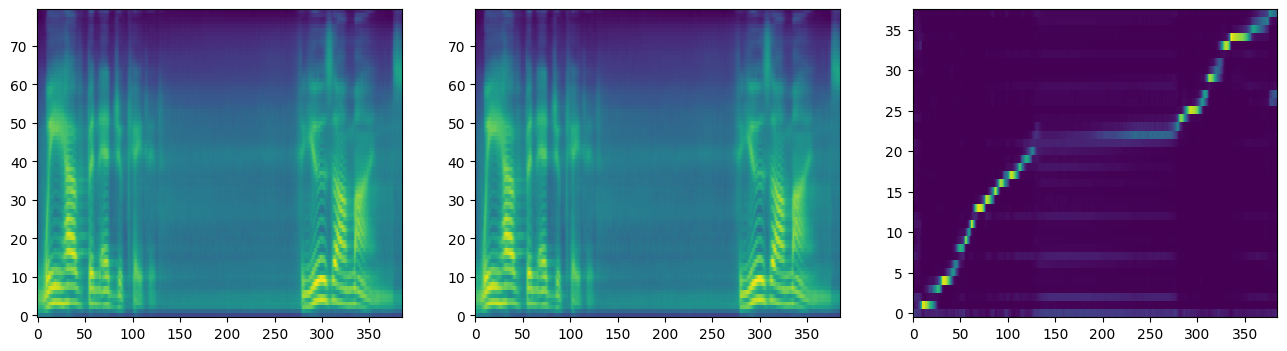

In [82]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)  #304,000
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [83]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=1) #0.666
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [84]:
audio_denoised = denoiser(audio, strength=0.05)[:, 0] #0.01
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 